<h1 align="center"><b>Linear Regression and Decision Tree Machine Learning Models</b></h1>

We will perform a big data analysis on Deerfoot Trail by creating Linear Regression and Decision Tree models to predict the commute time. The three files accompanying this notebook are deerfoot_commute_times.csv, weather_data_01012013_12312013.csv and weather_data_01012014_12312014.csv. There are three sections in this notebook:
+ Section 1: Data Preprocessing
+ Section 2: Creating Models
+ Section 3: Comparing Performance

### *Section 1: Data Preprocessing*
#### (1a) The first step in creating a machine learning model is preparing the datasets. In this section, we will clean the data and extract the required fields.

In [ ]:
import os.path

#Creating directory paths to access the data in the csv files
baseDir = os.path.join('.')

inputPath1 = os.path.join('/FileStore/shared_uploads/salim.kassouri1@ucalgary.ca/deerfoot_commute_times.csv')
inputPath2 = os.path.join('/FileStore/shared_uploads/salim.kassouri1@ucalgary.ca/weather_data_01012013_12312013.csv')
inputPath3 = os.path.join('/FileStore/shared_uploads/salim.kassouri1@ucalgary.ca/weather_data_01012014_12312014.csv')

fileName1 = os.path.join(baseDir, inputPath1)
fileName2 = os.path.join(baseDir, inputPath2)
fileName3 = os.path.join(baseDir, inputPath3)

#Scanning the text file into PySpark RDD type
deerfootRDD = sc.textFile(fileName1, 8)
weather2013RDD = sc.textFile(fileName2,8)
weather2014RDD = sc.textFile(fileName3,8)


#### (1b) Here we are extracting the wanted data from the Deerfoot Trail Records.

In [ ]:
#GETTING DAY[0], DATE[1] AND COMMUTE TIME FOR RUSH HOUR (6~9AM[4~7] AND 4~6PM[14~16])
def extractFields(deerfootRDDRecord):
 
    #split all data separted by ,
    fieldsList = deerfootRDDRecord.split(',') 
    hour = []
    
    #hour AM
    i = 4
    while i < 8:
        temp = (fieldsList[0],(fieldsList[1],fieldsList[i],i+2))
        hour.append(temp)
        i+=1
        
    #hour PM
    j=14
    while j < 17:
        temp = (fieldsList[0],(fieldsList[1],fieldsList[j],j+2))
        hour.append(temp)
        j+=1  
    
    return hour   
    
#USING FLAT MAP HERE TO SPLIT THE DATA INTO IT'S "KEYS"
deerfootPairRDD = deerfootRDD.flatMap(extractFields) 
print(deerfootPairRDD.take(2))

[('21/09/2013', ('Saturday', '34', 6)), ('21/09/2013', ('Saturday', '34', 7))]


#### (1c) In the weather data, there is a lot of "junk" content at the top, thus they need to be removed first. Using 2013 and 2014 as an indicator for 'non-junk' data.

In [ ]:
#CLEAN OUT ALL CONTENT EXCEPT FOR DATA
def filterLines(weatherRDDRecord): 
  
    #Unicode string string1 contains another string in variable string2 using 'u'string1' in string2'
    fieldsList = weatherRDDRecord.split(',')
    if u'2013' in fieldsList[0] or u'2014' in fieldsList[0]: 
        return True 
    else:
        #Discard unwanted metadata and header. 
        return False

#FILTER OUT UNWANTED DATA
filteredWeather2013RDD = weather2013RDD.filter(filterLines)
filteredWeather2014RDD = weather2014RDD.filter(filterLines)
print(filteredWeather2013RDD.take(5))
print(filteredWeather2014RDD.take(5))

['2013-01-01,2013,1,1,�,1.2,,-8.9,,-3.9,,21.9,,0,,0,T,0,,0,T,4,,33,,48,', '2013-01-02,2013,1,2,�,5.8,,-10.9,,-2.6,,20.6,,0,,0,,0,,0,,3,,29,,41,', '2013-01-03,2013,1,3,�,8.8,,-8.8,,0,,18,,0,,0,,0,,0,,2,,28,,52,', '2013-01-04,2013,1,4,�,2.9,,-11.2,,-4.2,,22.2,,0,,0,,0,,0,,2,,26,,63,', '2013-01-05,2013,1,5,�,4.8,,-10,,-2.6,,20.6,,0,,0,,0,,0,,1,,27,,41,']
['2014-01-01,2014,1,1,�,-0.6,,-9.7,,-5.2,,23.2,,0,,0,,1,,0.8,,9,,27,,30,', '2014-01-02,2014,1,2,�,8.5,,-10,,-0.8,,18.8,,0,,0,,0,,0,,11,,27,,52,', '2014-01-03,2014,1,3,�,3,,-11,,-4,,22,,0,,0,,7.8,,5.8,,8,,36,,54,', '2014-01-04,2014,1,4,�,-11,,-21.9,,-16.5,,34.5,,0,,0,,1,,0.2,,14,,35,,44,', '2014-01-05,2014,1,5,�,-14.4,,-25.5,,-20,,38,,0,,0,T,0,,0,T,14,,36,,52,']


#### (1d) Reorganize the data by splitting them into a list and then joining them again after reordering using python list arrangement syntax.

In [ ]:
def fixDate(weatherRDDRecord):
    fieldList = weatherRDDRecord.split(',')
    year,month,day = fieldList[0].split('-')
    return (day+'/'+month+'/'+year, ', '.join(fieldList[1:]))
   
fixedWeather2013RDD = filteredWeather2013RDD.map(fixDate)
fixedWeather2014RDD = filteredWeather2014RDD.map(fixDate)
print(fixedWeather2013RDD.take(2))
print(fixedWeather2014RDD.take(2))

[('01/01/2013', '2013, 1, 1, �, 1.2, , -8.9, , -3.9, , 21.9, , 0, , 0, T, 0, , 0, T, 4, , 33, , 48, '), ('02/01/2013', '2013, 1, 2, �, 5.8, , -10.9, , -2.6, , 20.6, , 0, , 0, , 0, , 0, , 3, , 29, , 41, ')]
[('01/01/2014', '2014, 1, 1, �, -0.6, , -9.7, , -5.2, , 23.2, , 0, , 0, , 1, , 0.8, , 9, , 27, , 30, '), ('02/01/2014', '2014, 1, 2, �, 8.5, , -10, , -0.8, , 18.8, , 0, , 0, , 0, , 0, , 11, , 27, , 52, ')]


#### (1e) Deerfoot Trail commute time data starts on September 21, 2013, and ends on April 10, 2014, therefore we need to remove all dates outside this timeframe. The following procedure combines the two weather datasets, then filters out the dates that are not in the given time frame.

In [ ]:
def filterDates(weatherRDDRecord):
   
    value = weatherRDDRecord[1]
    fields = value.split(",")
   
    validMonths2013 = [u'9',u'10',u'11',u'12'] #list of 2013 months in Deerfoot data
    validSeptemberDays2013 = [u'21',u'22',u'23',u'24',u'25',u'26',u'27',u'28',u'29',u'30'] #list of sept days in 2013
    validAprilDays2014=[u'1',u'2',u'3',u'4',u'5',u'6',u'7',u'8',u'9',u'10'] #list of April days in 2014
    validMonths2014=[u'1',u'2',u'3',u'4'] #list of 2014 months in Deerfoot data
  
    #FILTER 2013 DAYS (format [year, month, date, ......])
    if fields[0] == u'2013':      
        if fields[1].strip() in validMonths2013:
            if fields[1].strip() == u'9':
                if fields[2].strip() in validSeptemberDays2013: #IF SEPT, RETURN TRUE FOR DATES IN ABOVE LIST
                    return True
                else:
                    return False
            else: #RETURN TRUE FOR ALL DATES IN VALID MONTHS IN 2013
                return True
        else: #RETURN FALSE FOR ALL DATES NOT IN VALID MONTHS IN 2013
            return False   
        
    #FILTER 2014 DAYS, same process as above   
    else:
        if fields[1].strip() in validMonths2014:
            if fields[1].strip() == u'4':
                if fields[2].strip() in validAprilDays2014:
                    return True
                else:
                    return False
            else:
                return True
        else:
            return False

aggregateWeatherRDD = fixedWeather2013RDD.union(fixedWeather2014RDD)  
print(aggregateWeatherRDD.count())
desiredWeatherRDD = aggregateWeatherRDD.filter(filterDates)
print(desiredWeatherRDD.count())

730
202


#### (1f) Now join the Deerfoot data RDD and the weather data RDD together into one RDD using the join method.

In [ ]:
combinedPairRDD = deerfootPairRDD.join(desiredWeatherRDD) #should automatically join using Date and Day column
print(combinedPairRDD.count()) #check to see if any rows were lost
print(combinedPairRDD.take(1))

1414
[('30/09/2013', (('Monday', '40', 6), '2013, 9, 30, �, 14.3, , 2.2, , 8.3, , 9.7, , 0, , 0, , 0, , 0, , 0, , 26, , 72, '))]


#### (1g) Our models will focus on the weekdays, therefore the following method will filter out weekends.

In [ ]:
def filterWeekends(combinedPairRDDRecord):
    value=combinedPairRDDRecord[1]
    if value[0][0]==u'Saturday' or value[0][0]==u'Sunday':
        return False
    else:
        return True

#APPLY FILTER
combinedPairRDDWeekdays = combinedPairRDD.filter(filterWeekends)

#### (1h) Referring to the column headings in the given weather data, we are using the max temperature, min temperature, mean temperature, heat degree days, total rain, total snow, total precip, and snow on ground columns as the features in our models. 

#### We tested several models with different subsets of features and concluded that the decision tree model performed well when utilizing all the features above.  We were able to optimize this model by tuning certain hyperparameters rather than changing the number of features. The weekday feature was mapped to an integer in the range 1 to 5.

In [ ]:
def extractRegressionData(combinedPairRDDWeekdaysRecord):
    
    #extract all the values
    values = combinedPairRDDWeekdaysRecord[1]

    year, month, day, dq, max_temp, mtf, min_temp, mtf1, mean_temp, mtf2, heat_deg_days, hddf, cdd, cddf, total_rain, trf, total_snow, tsf, total_precip, tpf, snow_on_ground, sogf, dir_max_gust, dmgf, speed_max_gust, smgf = values[1].split(",")

    
    #extract the features for the regression model 
    max_temp = max_temp.strip()
    min_temp = min_temp.strip() 
    mean_temp = mean_temp.strip()
    heat_deg_days = heat_deg_days.strip()
    total_rain = total_rain.strip()
    total_snow = total_snow.strip()
    total_precip = total_precip.strip()
    snow_on_ground = snow_on_ground.strip()
    dir_max_gust = dir_max_gust.strip()
    speed_max_gust = speed_max_gust.strip()
        
    #map the weekday to an interger 
    if values[0][0] == u'Monday':
        date_num = '1'
    elif values[0][0] == u'Tuesday':
        date_num = '2'
    elif values[0][0] == u'Wednesday':
        date_num = '3'
    elif values[0][0] == u'Thursday':
        date_num = '4'
    elif values[0][0] == u'Friday':
        date_num = '5'
    
    # construct the return record 
    returnRecord = str(values[0][1])+","+str(values[0][2])+","+date_num+","+max_temp+","+min_temp+","+mean_temp+","+heat_deg_days+","+total_rain+","+total_snow+","+total_precip+","+snow_on_ground+","+dir_max_gust+","+speed_max_gust
    
    return returnRecord

#EXTRACT REGRESSION DATA 
regressionDataRDD = combinedPairRDDWeekdays.map(extractRegressionData)
print(regressionDataRDD.count())
print(regressionDataRDD.take(10))


1008
['40,6,1,14.3,2.2,8.3,9.7,0,0,0,0,26,72', '41,7,1,14.3,2.2,8.3,9.7,0,0,0,0,26,72', '47,8,1,14.3,2.2,8.3,9.7,0,0,0,0,26,72', '40,9,1,14.3,2.2,8.3,9.7,0,0,0,0,26,72', '42,16,1,14.3,2.2,8.3,9.7,0,0,0,0,26,72', '44,17,1,14.3,2.2,8.3,9.7,0,0,0,0,26,72', '44,18,1,14.3,2.2,8.3,9.7,0,0,0,0,26,72', '36,6,1,1.6,-13.8,-6.1,24.1,0,0,0,3,30,30', '36,7,1,1.6,-13.8,-6.1,24.1,0,0,0,3,30,30', '37,8,1,1.6,-13.8,-6.1,24.1,0,0,0,3,30,30']


### *Section 2: Creating Models*
#### (2a) Now that we have preprocessed all of the needed data, we can start modelling. The following method will input all the raw data into a LabeledPoint type. The first column is commute time which is the label, and the other columns are the features.

In [ ]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

def parsePoint(line):
    label_features = line.split(',')
    ret_val = LabeledPoint(label_features[0],label_features[1:])
    return ret_val

#CREATE LABELEDPOINTS FOR MODELS
parsedSamplePoints = regressionDataRDD.map(parsePoint)
print(parsedSamplePoints.take(7))


[LabeledPoint(40.0, [6.0,1.0,14.3,2.2,8.3,9.7,0.0,0.0,0.0,0.0,26.0,72.0]), LabeledPoint(41.0, [7.0,1.0,14.3,2.2,8.3,9.7,0.0,0.0,0.0,0.0,26.0,72.0]), LabeledPoint(47.0, [8.0,1.0,14.3,2.2,8.3,9.7,0.0,0.0,0.0,0.0,26.0,72.0]), LabeledPoint(40.0, [9.0,1.0,14.3,2.2,8.3,9.7,0.0,0.0,0.0,0.0,26.0,72.0]), LabeledPoint(42.0, [16.0,1.0,14.3,2.2,8.3,9.7,0.0,0.0,0.0,0.0,26.0,72.0]), LabeledPoint(44.0, [17.0,1.0,14.3,2.2,8.3,9.7,0.0,0.0,0.0,0.0,26.0,72.0]), LabeledPoint(44.0, [18.0,1.0,14.3,2.2,8.3,9.7,0.0,0.0,0.0,0.0,26.0,72.0])]


#### (2b) Now, we need to scale and normalize the feature values so that they are all within a small number range. The method is described below.

In [ ]:
#Scale and normalize the features. (featureValue-meanOfFeatureValues)/standardDeviationOfFeatureValues allows us to do that. Loop through all the features in the row.
def normalizeFeatures(lp):

    normalizedFeatures = list()
    for i in range(0,len(lp.features)):
        feature = (lp.features[i]-broadcastMean.value[i])/broadcastStdev.value[i]
        normalizedFeatures.insert(i,feature)
    return LabeledPoint(lp.label, normalizedFeatures)

#Here we obtain the nessesary values to do the above calculation since mean and sd is dependant on every value, we need to broadcast/globalize it so all workers can see. We loop through all features in a row to get their Mean and SD and add it to the list which we broadcast later. 
def getNormalizedRDD(nonNormalizedRDD): 

    meanList = list()
    stdevList = list()
    numFeatures = len(nonNormalizedRDD.take(1)[0].features)
    for i in range(0,numFeatures):
        featureRDD = nonNormalizedRDD.map(lambda lp: lp.features[i])
        featureMean = featureRDD.mean()
        featureStdev = featureRDD.stdev()
        meanList.insert(i,featureMean)
        stdevList.insert(i,featureStdev)
    global broadcastMean 
    broadcastMean = sc.broadcast(meanList)
    global broadcastStdev 
    broadcastStdev = sc.broadcast(stdevList)
    returnRDD = nonNormalizedRDD.map(normalizeFeatures)
    return returnRDD

normalizedSamplePoints = getNormalizedRDD(parsedSamplePoints)
print(normalizedSamplePoints.take(5))

[LabeledPoint(40.0, [-1.1591546816416394,-1.4093629876944578,1.2044343380608373,1.3120799229634246,1.2914096933514234,-1.2956196560682385,-0.10479836211782687,-0.32147182897435855,-0.28881038091969247,-0.714647277072183,0.15149527937243126,2.083678170496808]), LabeledPoint(41.0, [-0.951101277244422,-1.4093629876944578,1.2044343380608373,1.3120799229634246,1.2914096933514234,-1.2956196560682385,-0.10479836211782687,-0.32147182897435855,-0.28881038091969247,-0.714647277072183,0.15149527937243126,2.083678170496808]), LabeledPoint(47.0, [-0.7430478728472045,-1.4093629876944578,1.2044343380608373,1.3120799229634246,1.2914096933514234,-1.2956196560682385,-0.10479836211782687,-0.32147182897435855,-0.28881038091969247,-0.714647277072183,0.15149527937243126,2.083678170496808]), LabeledPoint(40.0, [-0.5349944684499872,-1.4093629876944578,1.2044343380608373,1.3120799229634246,1.2914096933514234,-1.2956196560682385,-0.10479836211782687,-0.32147182897435855,-0.28881038091969247,-0.714647277072183,0

#### (2c) Here we simply split the data into training and test/validation sets. Letting 80% of features and labels be training and 20% be validation.

In [ ]:
weights = [.8, .2] # train/test split
seed = 0 #set to 0 but can be anything from 0~100
parsedTrainData, parsedValData = normalizedSamplePoints.randomSplit(weights,seed)
parsedTrainData.cache() #cache it to prevent constant computation
parsedValData.cache()

#These commands are for double checking purposes. 
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
print(nTrain, nVal, nTrain + nVal)
print(normalizedSamplePoints.count())

786 222 1008
1008


#### (2d) The baseline model will calculate the average commute time for the training dataset. This model is simple and effective but doesn't take into account external factors like wind, snow, etc.

In [ ]:
averageCommuteTime = (parsedTrainData.map(lambda s: s.label)).mean()
print(averageCommuteTime)

41.852417302798976


#### (2e) We will use the Root Mean Squared Error (RMSE) for evaluation purposes since it is a practical approach. The equation involves calculating (actual - predicted)^2 for the squared error and then we take the mean and square root it.

In [ ]:
import math
def squaredError(label, prediction):
  
    sqrError = (label-prediction)*(label-prediction)
    return sqrError

def calcRMSE(labelsAndPreds):
   
    sqrSum = labelsAndPreds.map(lambda s: squaredError(s[0],s[1])).sum() #map all sqr error in the set(37)
    return math.sqrt(sqrSum/labelsAndPreds.count()) #take the mean by taking sum/count and then square rooting it


#### (2f) Now let's calculate the training and validation RMSE of the baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of commute time).

In [ ]:
labelsAndPredsTrain = parsedTrainData.map(lambda s: (s.label,averageCommuteTime))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda s: (s.label,averageCommuteTime))
rmseValBase = calcRMSE(labelsAndPredsVal)

print("Baseline Train RMSE = \t\t", rmseTrainBase)
print("Baseline Validation RMSE = \t", rmseValBase)

Baseline Train RMSE = 		 7.823504776062621
Baseline Validation RMSE = 	 6.105242587923208


#### (2g) The following procedure will train a Linear Regression (LR) model with L2 regularization (ridge regression) and with an intercept. The model parameters are stated below.

In [ ]:
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LinearRegressionWithSGD

#Values to use when training the linear regression model
numIters = 500           # iterations
alpha = 1.0              # step
miniBatchFrac = 1.0      # miniBatchFraction
reg = 1e-1               # regParam
regType = 'l2'           # regType
useIntercept = True      # intercept

#Fitting the paramteres and data into the model 
LR_Model = LinearRegressionWithSGD.train(parsedTrainData,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

# view model weights and intercept
LR_weights = LR_Model.weights          
LR_intercept = LR_Model.intercept
print(LR_weights, LR_intercept)

[1.357145990865371,-0.24234927279787769,0.4892053535587719,-0.48003301582486607,0.043468797677291234,-0.1861441276617077,-0.1997594644820004,1.3055081284125065,0.5523389130284514,1.9018440586607366,-0.41047485205227197,-0.07194992278064424] 38.0565498072625


#### (2h) Instead of using typical regression models such as ridge, lasso and Linear Regression with Stochastic Gradient Descent, since we use a lot of features, we decided to use a Decision Tree (DT) regression model for our dataset. It uses a tree-like model of decisions thus is efficient when it comes to dealing with a lot of input features. We can set an appropriate maximum depth to prevent it from overfitting as well. If one sets max_depth too high, then the decision tree might simply overfit the training data without capturing useful patterns as we would like; this will cause the testing error to increase. But if we set it too low, that is not good as well; then we might be giving the decision tree too little flexibility to capture the patterns and interactions in the training data. This will also cause the testing error to increase. 

#### Thus through testing multiple models, we will find the most optimal one. The node impurity is a measure of the homogeneity of the labels at the node, thus is set to variance to measure for regression. The number of bins is used when discretizing continuous features. Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions. However, it also increases computation and communication. For us, increased computation and communication are not of priority, since the dataset isn't as big as others. 

#### In terms of the validation set, we can prevent overfitting and underfitting problems by increasing and reducing the maxDepth and maxBin of the tree, thus we didn't create a split for them in the above splitting. We decided to settle on maxDepth being set to 8 and maxBins set to 64 because it gave us the best balance between Accuracy and RMSE.

In [ ]:
#DECISION TREE MODEL
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

DT_Model = DecisionTree.trainRegressor(parsedTrainData, categoricalFeaturesInfo={}, impurity = 'variance', maxDepth=8, maxBins=64)


#### (2i) The following code uses a sample point from the training set to do an initial test of the prediction using the Linear Regression and Decision Tree models.

In [ ]:
#SAMPLE PREDICTION USING LR AND DT MODELS
samplePoint = parsedTrainData.take(1)[0]

samplePrediction = LR_Model.predict(samplePoint.features)
print(samplePrediction)

samplePrediction_2 = DT_Model.predict(samplePoint.features)
print(samplePrediction_2)


34.952123837813964
40.8235294117647


#### (2j) The following procedure will calculate the RMSE of the Decision Tree model for the training and validation set.

In [ ]:
#THE VALIDATION RMSE OF THE DECISION TREE MODEL
pred = DT_Model.predict(parsedValData.map(lambda x: x.features))
#Zips this RDD with another one, returning key-value pairs with the first element in each RDD second element in each RDD.
labelsAndPredictions = parsedValData.map(lambda lp: lp.label).zip(pred)
rmseValDT = calcRMSE(labelsAndPredictions)

#THE TRAINING RMSE OF THE DECISION TREE MODEL
pred2 = DT_Model.predict(parsedTrainData.map(lambda x: x.features))
lp2 = parsedTrainData.map(lambda lp: lp.label).zip(pred2)
rmseTrainDT = calcRMSE(lp2)
print("Decision Tree Model Train RMSE: \t", rmseTrainDT)
print("Decision Tree Model Validation RMSE: \t", rmseValDT)

Decision Tree Model Train RMSE: 	 4.053937256410641
Decision Tree Model Validation RMSE: 	 5.148667196355478


### *Section 3: Comparing Performance*
#### (3a) Now we use the three models to predict the commute time for the validation set. Then we compare the predictions to the corresponding labels to get the RMSE.

#### Looking at the results, we can see the Decision Tree model is the best performing model, therefore we decided it was the best choice model to visualize its performance.

In [ ]:
#LINEAR REGRESSION MODEL
labelsAndPreds = parsedValData.map(lambda lp: (lp.label,LR_Model.predict(lp.features)))
rmseValLR = calcRMSE(labelsAndPreds)

#COMPARE THE VALIDATION RMSE OF THE MODELS
print("Baseline Model RMSE: \t\t", rmseValBase)
print("Linear Regression Model RMSE: \t", rmseValLR)
print("Decision Tree Model RMSE: \t", rmseValDT)

Baseline Model RMSE: 		 6.105242587923208
Linear Regression Model RMSE: 	 6.356808518303063
Decision Tree Model RMSE: 	 5.148667196355478


#### (3b) The following Random Forest (RF) model is from sample code in the course and is here to compare the performance of the various models.

In [ ]:
from pyspark.mllib.tree import RandomForest
from pyspark.ml.evaluation import RegressionEvaluator

#CREATE THE RANDOM FOREST MODEL
RF_Model = RandomForest.trainRegressor(parsedTrainData, categoricalFeaturesInfo={},
                                      numTrees=8, featureSubsetStrategy="auto",
                                      impurity='variance', maxDepth=5, maxBins=32)
predictions = RF_Model.predict(parsedValData.map(lambda x: x.features)).collect()
labels = parsedValData.map(lambda x: x.label).collect()
rmseValRF = np.sqrt(np.mean((np.array(predictions)-np.array(labels))**2))

#COMPARE THE RMSE OF THE MODELS
print("Baseline Model RMSE: \t\t", rmseValBase)
print("Linear Regression Model RMSE: \t", rmseValLR)
print("Decision Tree Model RMSE: \t", rmseValDT)
print("Random Forest Model RMSE: \t", rmseValRF)

Baseline Model RMSE: 		 6.105242587923208
Linear Regression Model RMSE: 	 6.356808518303063
Decision Tree Model RMSE: 	 5.148667196355478
Random Forest Model RMSE: 	 5.125760455739013


#### (3c) Regarding the results, due to the way the RF model behaves, the RMSE fluctuates a decent amount, sometimes the RMSE is lower (better) than the DT model and sometimes it is higher (worse) than the model. Therefore we concluded, since both of the results are quite low already and considering how inconsistent RF results are, we decided to use the DT model which gives us consistent results.

#### The following code is from sample code in the course and will draw a scatter plot of the predicted commute time (x-axis) and actual commute time (y-axis). This figure will allow us to visualize the performance of the DT model. If we observe a strong positive linear correlation, then the model is probably overfitting the dataset. In contrast, if there is no correlation that the model is underfitting. We can observe a weak positive correlation for the DT model.

(222,)


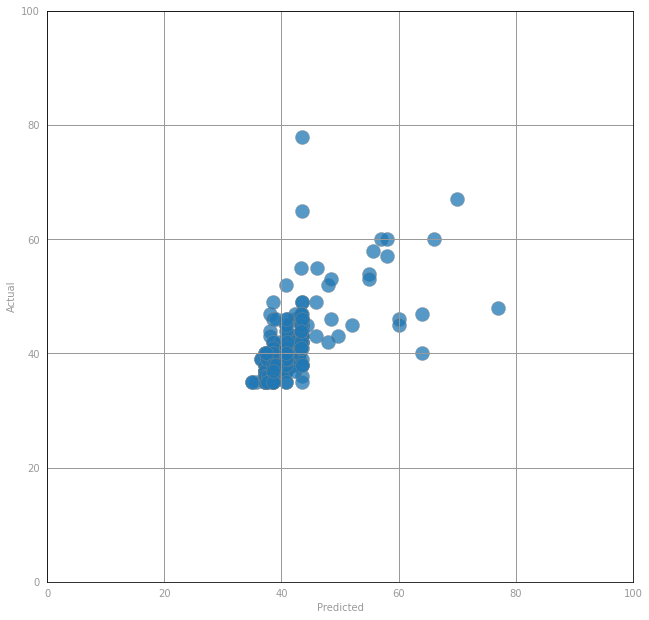

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap

cmap = get_cmap('YlOrRd')

#preparing a figure for the graph to be showcased. 
def preparePlot(xticks, yticks, figsize=(10.5, 10.5), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

#inputting RDD data into Numpy Arrays so we can plot easier
predictions = np.asarray(DT_Model.predict(parsedValData.map(lambda x: x.features))
                         .collect())
print(predictions.shape)

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label).collect())

error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, predictions)).map(lambda lp: squaredError(lp[0], lp[1]))
                   .collect())

#creating the plot and figure 
fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(0, 100), ax.set_ylim(0, 100)
plt.scatter(predictions, actual, s=14**2, c=None, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

#### (3d) The following code will calculate the accuracy of the baseline, LR and DT models. The accuracy formula provides accuracy as a difference of error rate from 100%. To find accuracy we first need to calculate the error rate. The error rate is the percentage value of the difference between the observed and the actual value, divided by the actual value. We will take the average of the Error Rate by summing all error rates of the rows and dividing by the count.

In [ ]:
def errorRate(label, prediction):
    error = abs(prediction - label)
    retVal = error/label*100
    return retVal

def calcAccuracy(labelsAndPreds):
    errorRateSum= labelsAndPreds.map(lambda s: errorRate(s[0],s[1])).sum() #map all error rate in the set.
    average = (errorRateSum/labelsAndPreds.count()) #take the mean by taking sum/count. 
    accuracy = 100 - average
    return accuracy

accuracyBase = calcAccuracy(labelsAndPredsVal)
accuracyLR = calcAccuracy(labelsAndPreds)
accuracyDT = calcAccuracy(labelsAndPredictions)

print("Baseline Model Accuracy: \t\t", accuracyBase)
print("Linear Regression Model Accuracy: \t", accuracyLR)
print("Decision Tree Model Accuracy: \t\t", accuracyDT)

Baseline Model Accuracy: 		 89.69866627006647
Linear Regression Model Accuracy: 	 90.01572695611036
Decision Tree Model Accuracy: 		 93.28488439412799


#### (3e) Now, we will finally create some sample weather data and day (not the commute time because we are trying to predict it) and use our model to create a "change in commute time over rush hour times" graph. We will first once again turn the data into LabelPoints and then normalize them (the commute time is set to 0 as a placeholder. Normalization takes into account the features only thus the 0 should affect the normalization process). After that, we will get a list of the predictions that will be plotted.

In [ ]:
import copy
weatherValues = [4,11.8,0.2,6,12,0,0,0,1,27,61] #the sample values we created accordingly to each other (So mean temp is correct and corresponds to the min and max temp etc...)

#rush hour hours (24 hour clock)
hourList = [6,7,8,9,16,17,18]
data = []

#in this loop all we do is put the hours into the sample data and convert each iteration into a singular string and put it into a list. 
for hour in hourList:
    features = copy.deepcopy(weatherValues)
    features.insert(0,hour)
    features.insert(0,40)
    string_numbers = [str(num) for num in features]
    str1 = ','.join(string_numbers)
    data.append(str1)
    
#cnvert the list into a RDD type, thus the format of the data is the same as above when we trained and validated our model
rdd = sc.parallelize(data)
#print(rdd.take(7))
#print("\n")

#parse the data now
parsedRDD = rdd.map(parsePoint)
#print((parsedRDD.take(7)))
#print("\n")

#normalize it
normie = getNormalizedRDD(parsedRDD)
#print(normie.take(7))
#print("\n")

#using collect, we can extract RDD data into a list
predictions = []
lpList = normie.collect() 

#get all predictions for the hours(each row basically)
for norm in lpList:
    prediction = DT_Model.predict(norm.features)
    predictions.append(prediction)
    
print(predictions)  

[58.0, 58.0, 58.0, 58.0, 88.0, 97.0, 105.0]


#### (3f) With all the predictions created, we can finally create a visual graph. We first add the predictions into 2 Numpy Arrays (AM and PM), then create the X-axis labels accordingly. After that, create figure and axis variables by using the subplot method. After that, plot 4 different graphs using 'ax' (Scatter for the points and regular plot to connect the dots, thus 2 graphs for AM and 2 more of the PM). Then change the figure size using 'f'.

Out[110]: (40.0, 110.0)

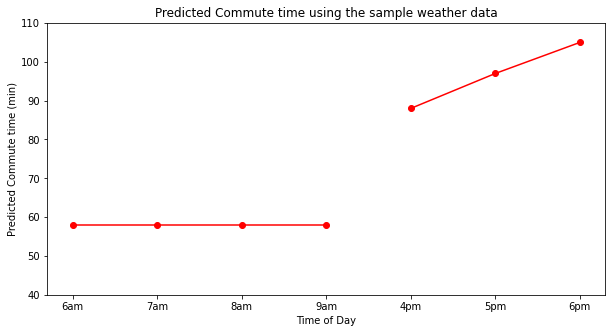

In [ ]:
listAM = np.array([predictions[0], predictions[1], predictions[2], predictions[3]])
listPM = np.array([predictions[4], predictions[5], predictions[6]])
x = ["6am","7am","8am","9am"]
fillerX = ["mid-day", "..",".."]
fillerY = np.array(["55","55","55"])
x2 = ["4pm", "5pm", "6pm"]

f, ax = plt.subplots(1)

ax.scatter(x, listAM, c='red')
ax.plot(x, listAM, c='red')

ax.scatter(x2, listPM, c='red')
ax.plot(x2, listPM, c='red')

f.set_figwidth(10)
f.set_figheight(5) 

plt.title("Predicted Commute time using the sample weather data")
plt.ylabel('Predicted Commute time (min)') 
plt.xlabel('Time of Day')  
ax.set_ylim(40, 110)

### *Acknowledgments*
#### We collaborated on this project with a team of five fellow university students. Portions of this notebook were adapted from external material provided to us by our professor at the University of Calgary.